# Lesson 8: Object Detection

**Note:**  `py-espeak-ng` is only available Linux operating systems.

To run locally in a Linux machine, follow these commands:
```
    sudo apt-get update
    sudo apt-get install espeak-ng
    pip install py-espeak-ng
```

### Build the `object-detection` pipeline using 🤗 Transformers Library

- This model was release with the paper [End-to-End Object Detection with Transformers](https://arxiv.org/abs/2005.12872) from Carion et al. (2020)


Info about [facebook/detr-resnet-50](https://huggingface.co/facebook/detr-resnet-50)

Explore more of the [Hugging Face Hub for more object detection models](https://huggingface.co/models?pipeline_tag=object-detection&sort=trending)

In [ ]:
# | echo:false

import io
import matplotlib.pyplot as plt
import requests
import inflect
from PIL import Image


def load_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw)


def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16, 10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:
        x, y = prediction["box"]["xmin"], prediction["box"]["ymin"]
        w = prediction["box"]["xmax"] - prediction["box"]["xmin"]
        h = prediction["box"]["ymax"] - prediction["box"]["ymin"]

        ax.add_patch(
            plt.Rectangle((x, y), w, h, fill=False, color="green", linewidth=2)
        )
        ax.text(
            x,
            y,
            f"{prediction['label']}: {round(prediction['score'] * 100, 1)}%",
            color="red",
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format="png", bbox_inches="tight", pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)

    # Close the plot to prevent it from being displayed
    plt.close()

    return modified_image


def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction["label"]
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are "
    for i, (label, count) in enumerate(summary.items()):
        count_string = p.number_to_words(count)
        result_string += f"{count_string} {label}"
        if count > 1:
            result_string += "s"

        result_string += " "

        if i == len(summary) - 2:
            result_string += "and "

    # Remove the trailing comma and space
    result_string = result_string.rstrip(", ") + "."

    return result_string


##### To ignore warnings #####
import warnings
import logging
from transformers import logging as hf_logging


def ignore_warnings():
    # Ignore specific Python warnings
    warnings.filterwarnings("ignore", message="Some weights of the model checkpoint")
    warnings.filterwarnings("ignore", message="Could not find image processor class")
    warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated")

    # Adjust logging for libraries using the logging module
    logging.basicConfig(level=logging.ERROR)
    hf_logging.set_verbosity_error()


########


### Use the Pipeline

In [ ]:
from transformers import pipeline

od_pipe = pipeline("object-detection", "facebook/detr-resnet-50")

raw_image = Image.open("../data/input/street-unsplash.jpg")
raw_image.resize((569, 491))
pipeline_output = od_pipe(raw_image)


/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/dataScience/deepleaning_ai/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a Be

Return the results from the pipeline using the helper function `render_results_in_image`.

In [ ]:
processed_image = render_results_in_image(raw_image, pipeline_output)


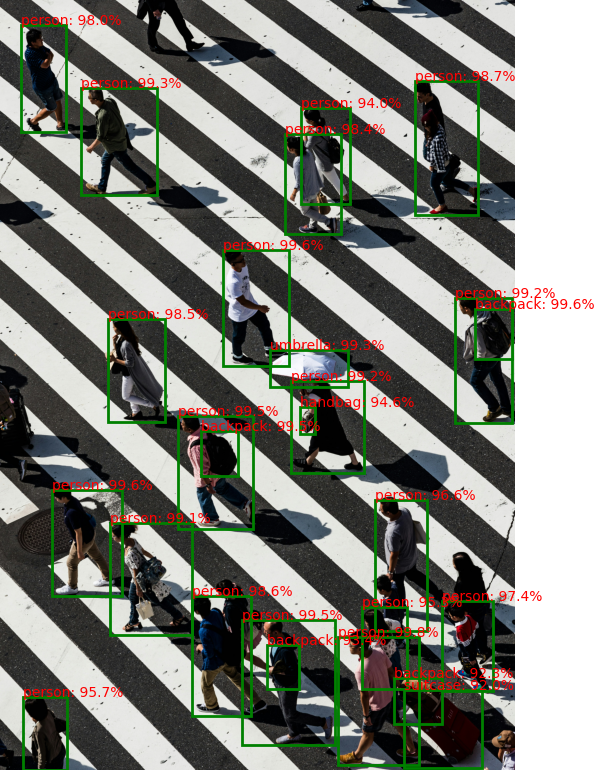

In [ ]:
processed_image


In [ ]:
# Free up some memory before continuing
import gc

del od_pipe
gc.collect()


4425

# Lesson 9: Segmentation

- In the classroom, the libraries are already installed for you.
- If you would like to run this code on your own machine, you can install the following:

```
    !pip install transformers
    !pip install gradio
    !pip install timm
    !pip install torchvision
```

### Mask Generation with SAM

The [Segment Anything Model (SAM)](https://segment-anything.com) model was released by Meta AI.

Info about [Zigeng/SlimSAM-uniform-77](https://huggingface.co/Zigeng/SlimSAM-uniform-77)

In [ ]:
# | echo: false

import numpy as np
import torch


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io

    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def show_mask_on_image(raw_image, mask, return_image=False):
    if not isinstance(mask, torch.Tensor):
        mask = torch.Tensor(mask)

    if len(mask.shape) == 4:
        mask = mask.squeeze()

    fig, axes = plt.subplots(1, 1, figsize=(15, 15))

    mask = mask.cpu().detach()
    axes.imshow(np.array(raw_image))
    show_mask(mask, axes)
    axes.axis("off")
    plt.show()

    if return_image:
        fig = plt.gcf()
        return fig2img(fig)


def show_pipe_masks_on_image(raw_image, outputs):
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    for mask in outputs["masks"]:
        show_mask(mask, ax=ax, random_color=True)
    plt.axis("off")
    plt.show()


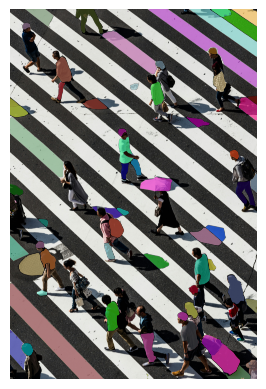

In [ ]:
from transformers import pipeline
from PIL import Image

sam_pipe = pipeline("mask-generation", "Zigeng/SlimSAM-uniform-77")

raw_image = Image.open("../data/input/street-unsplash.jpg")
raw_image.resize((720, 375))

# - Running this will take some time
# - The higher the value of 'points_per_batch', the more efficient pipeline inference will be

output = sam_pipe(raw_image, points_per_batch=32)
show_pipe_masks_on_image(raw_image, output)


In [ ]:
# Free up some memory before continuing
import gc

del sam_pipe
gc.collect()


8301

### Faster Inference: Infer an Image and a Single Point


In [ ]:
from transformers import SamModel, SamProcessor

model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

raw_image.resize((720, 375))
